# Variational Autoencoder (VAE)

## Prepare the data

In [1]:
import numpy as np
from matplotlib import pyplot as plt

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

import torchvision
from torchvision.utils import make_grid

device = torch.device("cuda")

In [2]:
class CropCelebA64:
    
    def __call__(self, pic):
        new_pic = pic.crop((15, 40, 178 - 15, 218 - 30))
        return new_pic

    def __repr__(self):
        return self.__class__.__name__ + '()'

In [ ]:
train_dataset = torchvision.datasets.CelebA(
    root='celeba',
    split='train',
    transform=torchvision.transforms.Compose([
        CropCelebA64(),
        torchvision.transforms.Resize(64),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        
        torchvision.transforms.Grayscale()
    ]),
)

validation_dataset = torchvision.datasets.CelebA(
    root='celeba',
    split='valid',
    transform=torchvision.transforms.Compose([
        CropCelebA64(),
        torchvision.transforms.Resize(64),
        torchvision.transforms.ToTensor(),
        
        torchvision.transforms.Grayscale()
    ]),
)

In [4]:
num_images = 10000
real_images_tensor = torch.stack([train_dataset[i][0] for i in range(num_images)], dim=0)
real_images = real_images_tensor.data.numpy().transpose([0, 2, 3, 1])
np.savez("real.npz", Pictures=real_images.reshape(num_images, 64 * 64 * 1))

In [110]:
real_images.shape

(10000, 64, 64, 1)

In [5]:
#!L
BATCH_SIZE = 64

# you may find useful parameters `num_workers` and `pin_memory`
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE)

# Autoencoder


In [23]:
dimZ = 100


class Autoencoder(nn.Module):
    
    def __init__(self):
        super(Autoencoder, self).__init__()

        # TODO

        self.encoder = nn.Sequential(
            nn.Linear(64*64, 256),
            nn.ReLU(),
            nn.Linear(256, dimZ)
        )
        self.decoder = nn.Sequential(
            nn.Linear(dimZ, 256),
            nn.ReLU(),
            nn.Linear(256, 64*64),
            nn.Sigmoid()
        )

        for layer in self.encoder:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                nn.init.zeros_(layer.bias)

        for layer in self.decoder:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                nn.init.zeros_(layer.bias)

    def forward(self, x):

        x = x.view(x.size(0), -1)
        latent_code = self.encoder(x)
        reconstruction = self.decoder(latent_code)
        reconstruction = reconstruction.view(-1, 1, 64, 64)
        return reconstruction, latent_code

In [24]:

criterion = torch.nn.MSELoss()

autoencoder = Autoencoder().to(device)

optimizer = optim.Adam(autoencoder.parameters())

In [25]:
num_epochs = 15
train_losses, val_losses = [], []

In [26]:
for epoch in range(num_epochs):
    epoch_loss = 0
    num_batches = 0
    autoencoder.train()
    for i, (imgs, _) in tqdm(enumerate(train_loader)):
        imgs = imgs.to(device)
        reconstruction, latent = autoencoder(imgs)

        loss = criterion(reconstruction, imgs)
        epoch_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        num_batches += 1
    
    # Вычисляем среднюю потерю за эпоху и добавляем в train_loss
    average_train_loss = epoch_loss / num_batches
    train_losses.append(average_train_loss)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {average_train_loss:.4f}')

    autoencoder.eval()
    epoch_val_loss = 0
    with torch.no_grad():
        for i, (val_imgs, _) in tqdm(enumerate(val_loader)):
            val_imgs = val_imgs.to(device)
            val_reconstruction, val_latent = autoencoder(val_imgs)
            val_loss = criterion(val_reconstruction, val_imgs)
            epoch_val_loss += val_loss.item()

            # Вычисляем среднюю валидационную потерю и добавляем в val_loss
        average_val_loss = epoch_val_loss / len(val_loader)
        val_losses.append(average_val_loss)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {average_val_loss:.4f}')





2544it [01:57, 21.65it/s]


Epoch [1/15], Training Loss: 0.0128


311it [00:14, 22.16it/s]


Epoch [1/15], Validation Loss: 0.0088


2544it [01:42, 24.79it/s]


Epoch [2/15], Training Loss: 0.0084


311it [00:12, 24.53it/s]


Epoch [2/15], Validation Loss: 0.0080


2544it [01:41, 25.04it/s]


Epoch [3/15], Training Loss: 0.0078


311it [00:12, 24.27it/s]


Epoch [3/15], Validation Loss: 0.0077


2544it [01:41, 24.96it/s]


Epoch [4/15], Training Loss: 0.0076


311it [00:12, 24.60it/s]


Epoch [4/15], Validation Loss: 0.0075


2544it [01:42, 24.90it/s]


Epoch [5/15], Training Loss: 0.0075


311it [00:12, 24.65it/s]


Epoch [5/15], Validation Loss: 0.0076


2544it [01:43, 24.64it/s]


Epoch [6/15], Training Loss: 0.0075


311it [00:12, 24.31it/s]


Epoch [6/15], Validation Loss: 0.0074


2544it [01:42, 24.85it/s]


Epoch [7/15], Training Loss: 0.0074


311it [00:12, 24.47it/s]


Epoch [7/15], Validation Loss: 0.0074


2544it [01:41, 24.95it/s]


Epoch [8/15], Training Loss: 0.0074


311it [00:11, 26.51it/s]


Epoch [8/15], Validation Loss: 0.0074


2544it [01:42, 24.77it/s]


Epoch [9/15], Training Loss: 0.0074


311it [00:12, 25.11it/s]


Epoch [9/15], Validation Loss: 0.0073


2544it [01:42, 24.85it/s]


Epoch [10/15], Training Loss: 0.0073


311it [00:11, 27.02it/s]


Epoch [10/15], Validation Loss: 0.0074


2544it [01:42, 24.80it/s]


Epoch [11/15], Training Loss: 0.0073


311it [00:12, 24.76it/s]


Epoch [11/15], Validation Loss: 0.0074


2544it [01:42, 24.86it/s]


Epoch [12/15], Training Loss: 0.0073


311it [00:12, 25.59it/s]


Epoch [12/15], Validation Loss: 0.0073


2544it [01:50, 23.00it/s]


Epoch [13/15], Training Loss: 0.0072


311it [00:12, 24.72it/s]


Epoch [13/15], Validation Loss: 0.0073


2544it [01:50, 22.96it/s]


Epoch [14/15], Training Loss: 0.0072


311it [00:12, 24.98it/s]


Epoch [14/15], Validation Loss: 0.0073


2544it [01:49, 23.28it/s]


Epoch [15/15], Training Loss: 0.0072


311it [00:12, 25.29it/s]

Epoch [15/15], Validation Loss: 0.0073


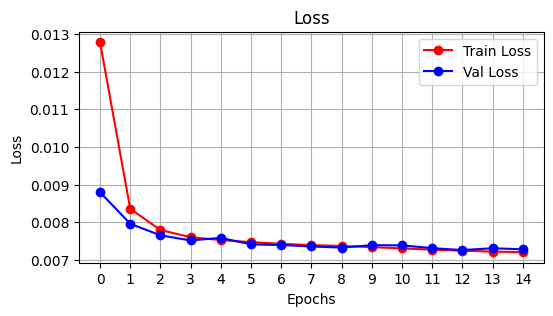

In [27]:
plt.figure(figsize=(6, 3))
plt.plot(train_losses, marker='o', linestyle='-', color='r', label='Train Loss')
plt.plot(val_losses, marker='o', linestyle='-', color='b', label='Val Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.xticks(range(len(train_losses)))
plt.legend()
plt.show()

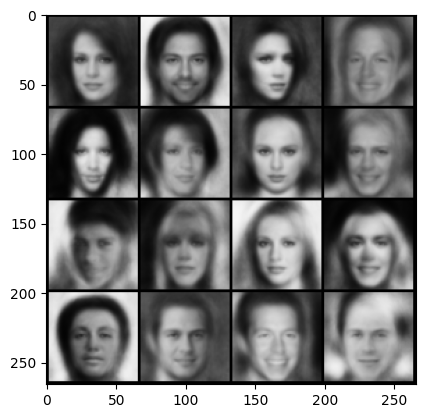

In [28]:
from itertools import islice

images, _ = list(islice(val_loader, 1))[0]
reconstruction, latent_code = autoencoder(images.to(device))

reconstruction = reconstruction[:16].cpu()
plt.imshow(make_grid(reconstruction, nrow=4).permute(1, 2, 0))

Reconstruction is not bad, right? 

# Sampling

Let's now sample several latent vectors and perform inference from $z$, reconstruct an image given some random $z$ representations.

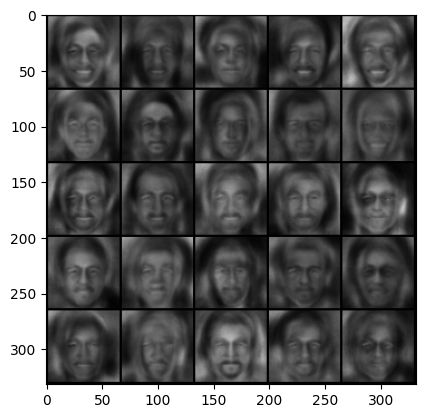

In [29]:
#!L
z = torch.randn(25, dimZ) * 0.5
reconstruction = autoencoder.decoder(z.to(device)).clamp(0, 1).view(-1, 1, 64, 64)
plt.imshow(make_grid(reconstruction.cpu(), nrow=5).permute(1, 2, 0))
plt.show()


So, if we sample $z$ from normal, whould we eventually generate all possible faces? What do you think?

# Variational Autoencoder

In [67]:

dimZ = 100


class VAE(nn.Module):
    
    def __init__(self):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(64*64, 400)
        self.fc_mu = nn.Linear(400, dimZ)  # Для mu
        self.fc_logsigma = nn.Linear(400, dimZ)  # Для логарифма sigma
        
        # Decoder
        self.fc2 = nn.Linear(dimZ, 400)
        self.fc_reconstruction_mu = nn.Linear(400, 64*64)  # Для mu реконструкции
        self.fc_reconstruction_logsigma = nn.Linear(400, 64*64)  # Для логарифма 

        self.relu = nn.ELU()
        self.sigm = nn.Sigmoid()

    def encode(self, x):

        h = self.relu(self.fc1(x))
        mu = self.sigm(self.fc_mu(h))
        logsigma = self.sigm(self.fc_logsigma(h))
        return mu, logsigma

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h = self.relu(self.fc2(z))
        reconstruction_mu = self.sigm(self.fc_reconstruction_mu(h))
        reconstruction_logsigma = self.fc_reconstruction_logsigma(h)
        return reconstruction_mu, reconstruction_logsigma

    def gaussian_sampler(self, mu, logsigma):
        noise = torch.randn_like(mu)
        return noise * logsigma.exp() + mu

    def forward(self, x):
        x = x.view(-1, 64*64)
        latent_mu, latent_logsigma = self.encode(x)
        z = self.reparameterize(latent_mu, latent_logsigma)
        reconstruction_mu, reconstruction_logsigma = self.decode(z)
        
        return reconstruction_mu, reconstruction_logsigma, latent_mu, latent_logsigma

In [ ]:

def KL_divergence(mu, logsigma):
    kl = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp(), dim=1)
    return kl

def log_likelihood(x, mu, logsigma):
    variance = logsigma.exp() + 1e-8
    log_prob = -torch.sum(logsigma) - 0.5 * torch.log(torch.tensor(2 * torch.pi)) - torch.sum((x - mu).pow(2) / (2 * variance), dim=1)
    return log_prob

def loss_vae(x, mu_gen, logsigma_gen, mu_z, logsigma_z):
    kl_div = KL_divergence(mu_z, logsigma_z)
    likelihood = log_likelihood(x, mu_gen, logsigma_gen)
    total_loss = -(kl_div + likelihood).mean()
    
    if torch.isnan(total_loss):
        print("Warning: NaN encountered in total_loss")
    
    return total_loss

And train the model:

In [69]:
num_epochs = 30
learning_rate = 0.0001
train_losses, val_losses = [], []

vae = VAE().to(device)

optimizer = optim.Adam(vae.parameters(), lr=learning_rate)

In [73]:
for epoch in range(num_epochs):
    epoch_loss = 0
    vae.train()
    for i, (imgs, _) in tqdm(enumerate(train_loader)):
        imgs = imgs.to(device)
        reconstruction_mu, reconstruction_logsigma, latent_mu, latent_logsigma = vae(imgs)
        loss = loss_vae(imgs.view(-1, 64*64), reconstruction_mu, reconstruction_logsigma, latent_mu, latent_logsigma)
        epoch_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    average_train_loss = epoch_loss / len(train_loader)
    train_losses.append(average_train_loss)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {average_train_loss:.4f}')

    vae.eval()
    epoch_val_loss = 0
    with torch.no_grad():
        for i, (val_imgs, _) in tqdm(enumerate(val_loader)):
            val_imgs = val_imgs.to(device)
            val_reconstruction_mu, val_reconstruction_logsigma, val_latent_mu, val_latent_logsigma = vae(val_imgs)
            val_loss = loss_vae(val_imgs.view(-1, 64*64), val_reconstruction_mu, val_reconstruction_logsigma, val_latent_mu, val_latent_logsigma)
            epoch_val_loss += val_loss.item()

            # Вычисляем среднюю валидационную потерю и добавляем в val_loss
        average_val_loss = epoch_val_loss / len(val_loader)
        val_losses.append(average_val_loss)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {average_val_loss:.4f}')



2544it [01:44, 24.41it/s]


Epoch [1/30], Training Loss: -1947354.4230


311it [00:12, 24.52it/s]


Epoch [1/30], Validation Loss: -1948063.9192


2544it [01:43, 24.58it/s]


Epoch [2/30], Training Loss: -1950269.0913


311it [00:11, 26.17it/s]


Epoch [2/30], Validation Loss: -1950955.1461


2544it [01:46, 23.91it/s]


Epoch [3/30], Training Loss: -1952785.3854


311it [00:12, 25.59it/s]


Epoch [3/30], Validation Loss: -1953622.3008


2544it [01:50, 23.10it/s]


Epoch [4/30], Training Loss: -1954964.4045


311it [00:12, 25.07it/s]


Epoch [4/30], Validation Loss: -1953681.1700


2544it [01:45, 24.04it/s]


Epoch [5/30], Training Loss: -1956048.5305


311it [00:12, 25.72it/s]


Epoch [5/30], Validation Loss: -1956278.9966


2544it [01:44, 24.37it/s]


Epoch [6/30], Training Loss: -1957402.1267


311it [00:11, 26.75it/s]


Epoch [6/30], Validation Loss: -1956775.0830


2544it [01:43, 24.50it/s]


Epoch [7/30], Training Loss: -1958184.6781


311it [00:11, 26.56it/s]


Epoch [7/30], Validation Loss: -1957354.2669


2544it [01:43, 24.52it/s]


Epoch [8/30], Training Loss: -1958735.6067


311it [00:12, 25.78it/s]


Epoch [8/30], Validation Loss: -1959008.0900


2544it [01:43, 24.50it/s]


Epoch [9/30], Training Loss: -1959720.5058


311it [00:12, 24.00it/s]


Epoch [9/30], Validation Loss: -1958805.1111


2544it [01:45, 24.16it/s]


Epoch [10/30], Training Loss: -1960515.8344


311it [00:13, 23.44it/s]


Epoch [10/30], Validation Loss: -1959862.0934


2544it [01:45, 24.14it/s]


Epoch [11/30], Training Loss: -1960547.5184


311it [00:13, 23.68it/s]


Epoch [11/30], Validation Loss: -1960743.5400


2544it [01:43, 24.66it/s]


Epoch [12/30], Training Loss: -1961517.6485


311it [00:12, 25.73it/s]


Epoch [12/30], Validation Loss: -1961340.6288


2544it [01:42, 24.73it/s]


Epoch [13/30], Training Loss: -1961740.5482


311it [00:12, 25.70it/s]


Epoch [13/30], Validation Loss: -1960398.9568


2544it [01:42, 24.79it/s]


Epoch [14/30], Training Loss: -1962093.5288


311it [00:11, 26.30it/s]


Epoch [14/30], Validation Loss: -1960852.6135


2544it [01:41, 24.99it/s]


Epoch [15/30], Training Loss: -1962560.1586


311it [00:12, 25.69it/s]


Epoch [15/30], Validation Loss: -1961694.8449


2544it [01:41, 25.10it/s]


Epoch [16/30], Training Loss: -1963478.7094


311it [00:12, 25.00it/s]


Epoch [16/30], Validation Loss: -1961425.8306


2544it [01:41, 25.03it/s]


Epoch [17/30], Training Loss: -1963353.6649


311it [00:11, 26.04it/s]


Epoch [17/30], Validation Loss: -1962289.4150


2544it [01:41, 25.10it/s]


Epoch [18/30], Training Loss: -1963942.5802


311it [00:11, 26.03it/s]


Epoch [18/30], Validation Loss: -1963897.5245


2544it [01:41, 25.08it/s]


Epoch [19/30], Training Loss: -1964414.9869


311it [00:12, 25.53it/s]


Epoch [19/30], Validation Loss: -1963581.9940


2544it [01:41, 25.01it/s]


Epoch [20/30], Training Loss: -1964520.1462


311it [00:12, 25.62it/s]


Epoch [20/30], Validation Loss: -1964119.6736


2544it [01:41, 25.05it/s]


Epoch [21/30], Training Loss: -1964983.6321


311it [00:11, 26.73it/s]


Epoch [21/30], Validation Loss: -1963476.1481


2544it [01:41, 25.01it/s]


Epoch [22/30], Training Loss: -1965554.6518


311it [00:11, 26.62it/s]


Epoch [22/30], Validation Loss: -1963952.9076


2544it [01:41, 25.08it/s]


Epoch [23/30], Training Loss: -1965558.5072


311it [00:12, 25.09it/s]


Epoch [23/30], Validation Loss: -1964125.6819


2544it [01:41, 25.04it/s]


Epoch [24/30], Training Loss: -1966069.7192


311it [00:12, 25.68it/s]


Epoch [24/30], Validation Loss: -1965261.6885


2544it [01:41, 25.03it/s]


Epoch [25/30], Training Loss: -1966215.2444


311it [00:12, 25.50it/s]


Epoch [25/30], Validation Loss: -1965213.3605


2544it [01:41, 25.13it/s]


Epoch [26/30], Training Loss: -1966803.8330


311it [00:12, 25.00it/s]


Epoch [26/30], Validation Loss: -1965438.6602


2544it [01:45, 24.14it/s]


Epoch [27/30], Training Loss: -1967006.4089


311it [00:13, 23.31it/s]


Epoch [27/30], Validation Loss: -1966373.5187


2544it [01:47, 23.60it/s]


Epoch [28/30], Training Loss: -1967301.3400


311it [00:12, 24.72it/s]


Epoch [28/30], Validation Loss: -1967610.7643


2544it [01:46, 23.88it/s]


Epoch [29/30], Training Loss: -1967480.5076


311it [00:12, 25.57it/s]


Epoch [29/30], Validation Loss: -1965547.6258


2544it [01:46, 23.85it/s]


Epoch [30/30], Training Loss: -1967824.7790


311it [00:11, 26.69it/s]

Epoch [30/30], Validation Loss: -1967147.7120


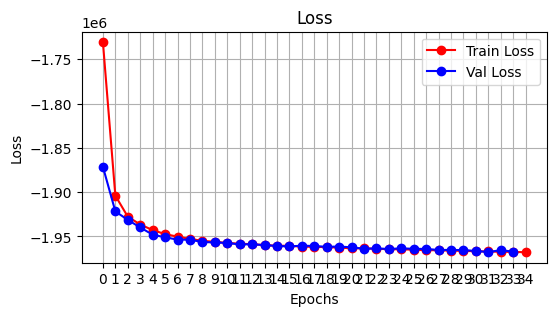

In [74]:
plt.figure(figsize=(6, 3))
plt.plot(train_losses, marker='o', linestyle='-', color='r', label='Train Loss')
plt.plot(val_losses, marker='o', linestyle='-', color='b', label='Val Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.xticks(range(len(train_losses)))
plt.legend()
plt.show()

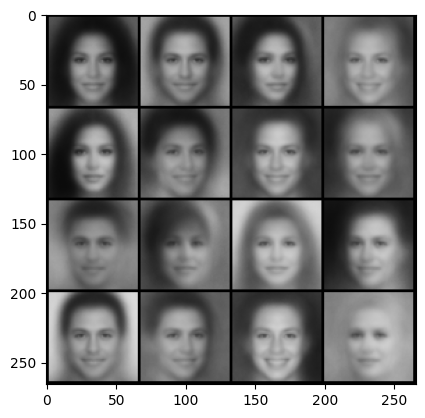

In [75]:
#!L
images, _ = list(islice(val_loader, 1))[0]
mu_gen, _, _, _ = vae(images.to(device))
reconstruction = mu_gen[:16].cpu().clamp(0, 1).view(-1, 1, 64, 64)

plt.imshow(make_grid(reconstruction, nrow=4).permute(1, 2, 0))

And finally sample from VAE.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-5378.4224..5420.184].


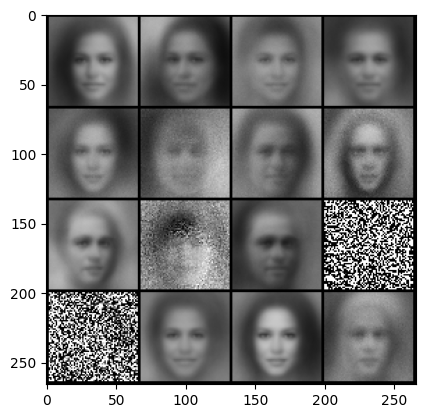

In [81]:
#!L
# TODO
# Sample some images from the learned distribution
# 1) Sample z ~ N(0,1)
# 2) Sample from N(decoder_mu(z), decoder_sigma(z))

z = torch.randn(16, dimZ)
reconstruction_mu, reconstruction_logsigma = vae.decode(z.to(device))

x_rec = vae.gaussian_sampler(reconstruction_mu, reconstruction_logsigma)
generated_images = x_rec.view(-1, 1, 64, 64)
plt.imshow(make_grid(generated_images.cpu(), nrow=4).permute(1, 2, 0))
plt.show()

Even if in practice you do not see the much difference between AE and VAE, or VAE is even worse, the little bayesian inside you should be jumping for joy right now. 

In VAE you can truly sample from image distribution $p(x)$, while in AE there is no easy and correct way to do it. 

# Add smiling

In [88]:
import pandas as pd

In [ ]:
path = 'celeba\celeba\list_attr_celeba.txt'

with open(path, 'r') as f:
    num_attributes = f.readline().strip()
    attributes = f.readline().strip().split()

In [1]:
data = pd.read_csv(path, delim_whitespace=True, skiprows=2, header=None)

data.columns = ['image_id'] + attributes
column_smile = data['Smiling']
column_name = data['image_id']


NameError: name 'pd' is not defined

In [422]:
smiling_imgs = []
unsmiling_imgs = []

i = 0
while(len(smiling_imgs) < 110):
    if column_smile[i] == 1:
        smiling_imgs.append(i)
    else:
        if len(unsmiling_imgs) < 10:
            unsmiling_imgs.append(i)
    i += 1

In [423]:
data_imgs = np.load("real.npz")
images = data_imgs['Pictures']


In [424]:
def compute_avgz_vae(idxs):
    z_list = []
    for i in idxs:
        img = images[i]
        mu, logsigm = vae.encode(torch.tensor(img).to(device))
        z = vae.reparameterize(mu, logsigm)
        z_list.append(z)
    z_mean = torch.stack(z_list)
    z_avg = torch.mean(z_mean, dim=0)
    return z_avg

In [425]:
z_avg_smile = compute_avgz_vae(smiling_imgs,)
z_avg_unsmile = compute_avgz_vae(unsmiling_imgs)

difference = z_avg_smile - z_avg_unsmile

In [426]:
def add_smile_vae(diff, img):
    mu, logsigm = vae.encode(torch.tensor(img).to(device))
    z = vae.reparameterize(mu, logsigm) + diff
    img, _ = vae.decode(z) 
    return img.cpu().detach().numpy()

In [427]:
img_test = images[122]

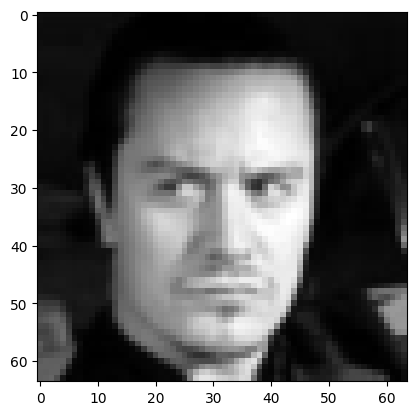

In [430]:
plt.imshow(img_test.reshape(64, 64), cmap='gray')

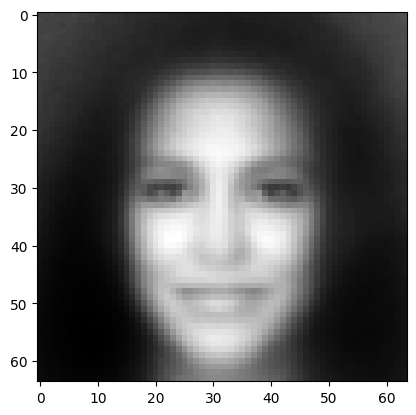

In [431]:
plt.imshow((add_smile_vae(difference, img_test)).reshape(64,64),  cmap='gray')

In [293]:
import cv2

In [432]:
def compute_avgz_au(idxs,):
    z_list = []
    for i in idxs:
        img = images[i]
        z = autoencoder.encoder(torch.tensor(img).to(device))
        z_list.append(z)
    z_mean = torch.stack(z_list)
    z_avg = torch.mean(z_mean, dim=0)
    return z_avg

In [433]:
def add_smile_ae(diff, img):
    z = autoencoder.encoder(torch.tensor(img).to(device)) + diff
    img_ae = autoencoder.decoder(z)
    img_ae = img_ae.view(64,64,1)
    img_ae = img_ae.cpu().detach().numpy()
    return img_ae


In [434]:
z_avg_smile = compute_avgz_au(smiling_imgs)
z_avg_unsmile = compute_avgz_au(unsmiling_imgs)

difference_ae = z_avg_smile - z_avg_unsmile

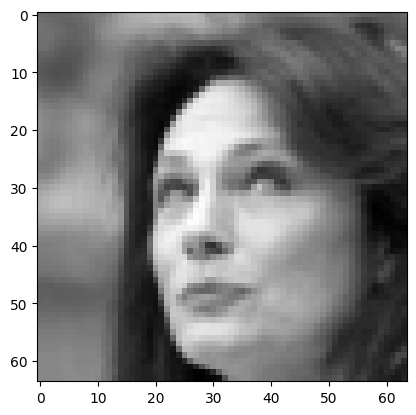

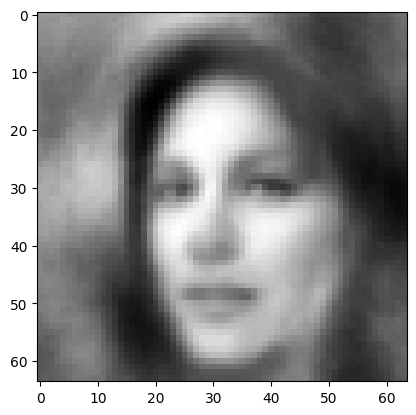

In [435]:
img_test = images[2081]

plt.imshow(img_test.reshape(64,64), cmap='gray')
plt.show()
plt.imshow(add_smile_ae(difference, img_test), cmap='gray')

In [436]:
def prepare_img(img):
    img_g = cv2.cvtColor(img,  cv2.COLOR_BGR2GRAY)
    img_fl = (img_g / 255).astype(np.float32)
    img_resize = cv2.resize(img_fl, (64, 64))
    return img_resize

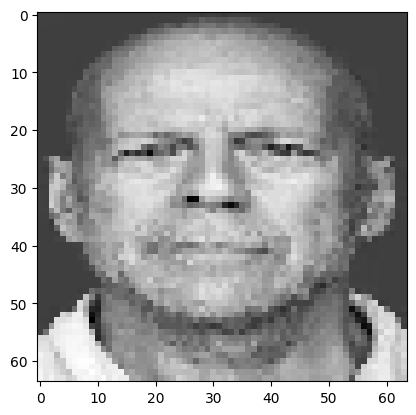

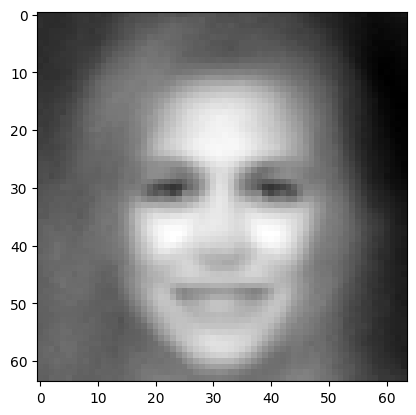

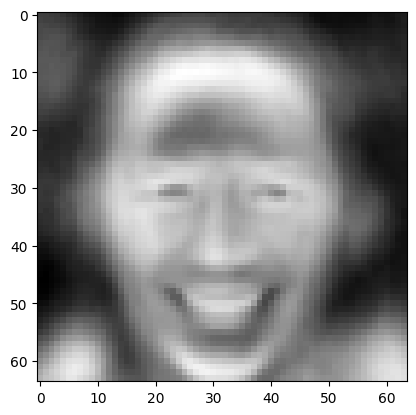

In [483]:
brus = cv2.imread('brus.jpg')
brus_pre = prepare_img(brus)
plt.imshow(brus_pre.reshape(64,64), cmap='gray')
plt.show()
plt.imshow(add_smile_vae(difference, brus_pre.reshape(64*64)).reshape(64,64), cmap='gray')
plt.show()
plt.imshow(add_smile_ae(difference_ae, brus_pre.reshape(64*64)).reshape(64,64) , cmap='gray')